# Network Analysis

In [54]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
from itertools import combinations

In [55]:
data_path = "data/"
output_path = "graphs/"

In [56]:
decades = list(range(1840, 2000, 10))
mentions_fr = pd.read_pickle(data_path + "mentions_fr.pkl")
mentions_de = pd.read_pickle(data_path + 'mentions_de.pkl')
mentions_all = pd.concat([mentions_fr, mentions_de])

In [57]:
mentions_all.head()

,entity,surface,qid,lSentenceOffset,rSentenceOffset,sentence_idx:,lArticleOffset,rArticleOffset,id,article,newspaper,date,year,decade,agency,language,country
0,org.ent.pressagency.Havas,Havas,Q2826560,30,35,1,84,89,LLE-1939-11-27-a-i0076:1:30:35:84:89:newsag:be...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,Havas,fr,CH
1,org.ent.pressagency.UP-UPI,United Press,Q493845,2,14,7,595,607,LLE-1939-11-27-a-i0076:7:2:14:595:607:newsag:b...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
2,org.ent.pressagency.UP-UPI,United Press,Q493845,0,12,10,1364,1376,LLE-1939-11-27-a-i0076:10:0:12:1364:1376:newsa...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
3,org.ent.pressagency.UP-UPI,United Press,Q493845,2,14,16,2181,2193,LLE-1939-11-27-a-i0076:16:2:14:2181:2193:newsa...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH
4,org.ent.pressagency.UP-UPI,Press,Q493845,48,53,18,2531,2536,LLE-1939-11-27-a-i0076:18:48:53:2531:2536:news...,LLE-1939-11-27-a-i0076,LLE,1939-11-27,1939,1930,UP-UPI,fr,CH


In [89]:
#get information on news agencies
df_newsagencies = mentions_all[['agency', 'year', 'language']].groupby('agency').agg(
    {'year': ['min', 'max'],
     'language': set}
)

df_newsagencies.columns = df_newsagencies.columns.map('_'.join)
df_newsagencies = df_newsagencies.rename(columns={'agency_' : 'agency', 'language_set': 'language', 'year_min':'start_year', 'year_max': 'end_year'})
df_newsagencies['language'] = df_newsagencies['language'].apply(lambda x: ", ".join(x))
df_newsagencies

,start_year,end_year,language
agency,,,
AFP,1813,2018,"de, fr"
AP,1807,2017,"de, fr"
ATS-SDA,1780,2018,"de, fr"
DDP-DAPD,1829,2006,de
DNB,1799,2007,"de, fr"
DPA,1790,2007,"de, fr"
Europapress,1913,2006,de
Extel,1808,2010,"de, fr"
Havas,1781,2017,"de, fr"


### Import newspaper list

In [90]:
newspapers = mentions_all[['newspaper', 'language', 'country']].groupby('newspaper').first()
newspapers.head()

,language,country
newspaper,,
BLB,de,CH
BNN,de,CH
CDV,fr,CH
CON,fr,CH
DFS,de,CH


In [91]:
np_info = pd.read_csv(data_path + "impresso_newspapers_abbrev_20230719.csv").set_index('id')
np_info.head()

,title,start_year,end_year
id,,,
actionfem,L'Action féminine,1927.0,1940.0
arbeitgeber,Schweizer Arbeitgeber,1906.0,1994.0
armeteufel,Arme Teufel,1903.0,1929.0
avenirgdl,L'avenir,1868.0,1871.0
BDC,Bulletin des séances de la Constituante,1839.0,1839.0


In [92]:
np_df = newspapers.join(np_info, how="left")
#check if data is missing
print(np_df.isna().sum())
np_df.head()

language      0
country       0
title         0
start_year    0
end_year      0
dtype: int64


,language,country,title,start_year,end_year
newspaper,,,,,
BLB,de,CH,Bündner Landbote,1846.0,1847.0
BNN,de,CH,Bündner Nachrichten,1885.0,1892.0
CDV,fr,CH,Courrier du Valais,1843.0,1857.0
CON,fr,CH,La Contrée,1902.0,1903.0
DFS,de,CH,Wochenblatt für die vier löblichen Kantone Ury...,1814.0,1849.0


## Create Multigraph

In [93]:
def make_multigraph(df, edge_cols, node_dfs=[], bipartite=True, node0='newspaper', node1='agency', print_attrs=True):
    """
    Creates (undirected) Multigraph with newspapers and/or agencies as nodes and the references between them as edges.

    Parameters
        :df: pd.Dataframe with edge data
        :edge_cols: list of columns of df which contain edge attributes
        :node_dfs: list of pd.Dataframes, each Dataframes containing data for node attributes
        :bipartite: if set to True, nodes from column node0 get attribute '0' and node1 get '1'
        :node0: column containing first node of an edge
        :node1: column containing second node of an edge
        :print_attrs: if set to True, beginnings of the edge- and node-list are printed to the screen

    Returns: nx.Multigraph G
    """

    #make edge list
    edge_attrs = df[edge_cols].to_dict(orient='records')
    edge_list = list(zip(df[node0], df[node1], edge_attrs))

    #create graph
    G = nx.MultiGraph()
    keys = G.add_edges_from(edge_list)

    #add node attributes
    for node_df in node_dfs:
        node_attrs = node_df.to_dict(orient='records')
        node_dict = dict(zip(node_df.index,  node_attrs))
        nx.set_node_attributes(G, node_dict)

    if bipartite:
        #set newspaper node attr to 0, agency node attr to 1
        N0 = mentions_all[node0].unique()
        N1 = mentions_all[node1].unique()

        bipartite_attrs = dict(  list(zip( N0, [{"bipartite": 0}] * len(N0) )) +
                        list(zip( N1, [{"bipartite": 1}] * len(N1) ))
                        )
        nx.set_node_attributes(G, bipartite_attrs)

    if print_attrs:
        print(f"Edge list: {edge_list[:5]} ...")
        print(f"Node list: {list(G.nodes.data())[:5]} ...")

    
    return G

In [94]:
G = make_multigraph(mentions_all, edge_cols=['date', 'year', 'decade', 'language'], node_dfs=[np_df, df_newsagencies], bipartite=True)

Edge list: [('LLE', 'Havas', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'}), ('LLE', 'UP-UPI', {'date': '1939-11-27', 'year': 1939, 'decade': 1930, 'language': 'fr'})] ...
Node list: [('LLE', {'language': 'fr', 'country': 'CH', 'title': 'La Liberté', 'start_year': 1871.0, 'end_year': 2018.0, 'bipartite': 0}), ('Havas', {'start_year': 1781, 'end_year': 2017, 'language': 'de, fr', 'bipartite': 1}), ('UP-UPI', {'start_year': 1782, 'end_year': 2017, 'language': 'de, fr', 'bipartite': 1}), ('Reuters', {'start_year': 1791, 'end_year': 2017, 'language': 'de, fr', 'bipartite': 1}), ('GDL', {'language': 'fr', 'country': 'CH', 'title': 'Gazette de Lausanne', 'start_year': 1804.0, 'end_year': 1991.0, 'bi

## Make Multigraph with Edges grouped by Year

In [95]:
mentions_yearly = mentions_all[['newspaper', 'agency', 'year', 'decade', 'language']].groupby(['newspaper', 'agency', 'year']).agg({
    'language': 'count',
    'decade': 'first'
}).reset_index().rename(columns={'language': 'weight'})
mentions_yearly.head()

,newspaper,agency,year,weight,decade
0,BLB,ATS-SDA,1847,1,1840
1,BLB,Havas,1846,1,1840
2,BLB,Reuters,1846,1,1840
3,BLB,SPK-SMP,1847,2,1840
4,BLB,unk,1847,1,1840


### Threshold

In [96]:
def get_percentage(df, col, value, decimals=0):
    df_selected = df[df[col] == value]
    return round(len(df_selected)/len(df)*100, decimals)

for value in range(1,13):
    print(f"%nodes with weight = {value}: {get_percentage(mentions_yearly, 'weight', value)}%")

%nodes with weight = 1: 24.0%
%nodes with weight = 2: 11.0%
%nodes with weight = 3: 6.0%
%nodes with weight = 4: 4.0%
%nodes with weight = 5: 3.0%
%nodes with weight = 6: 3.0%
%nodes with weight = 7: 2.0%
%nodes with weight = 8: 2.0%
%nodes with weight = 9: 2.0%
%nodes with weight = 10: 2.0%
%nodes with weight = 11: 1.0%
%nodes with weight = 12: 1.0%


In [122]:
#threshold >= 6: at least once every two months
mentions_yearly_min6 = mentions_yearly[mentions_yearly['weight'] >= 6]
#threshold >= 24: at least twice a month
mentions_yearly_min24 = mentions_yearly[mentions_yearly['weight'] >= 24]

### Make Graphs

In [123]:
print("Graph with all edges")
G_yearly = make_multigraph(mentions_yearly, edge_cols=['year', 'decade', 'weight'], node_dfs=[np_df, df_newsagencies], bipartite=True)
print("\nGraph with edges with weight above 5")
G_yearly_min6 = make_multigraph(mentions_yearly_min6, edge_cols=['year', 'decade', 'weight'], node_dfs=[np_df, df_newsagencies], bipartite=True)
print("\nGraph with edges with weight >= 24")
G_yearly_min24 = make_multigraph(mentions_yearly_min24, edge_cols=['year', 'decade', 'weight'], node_dfs=[np_df, df_newsagencies], bipartite=True)

Graph with all edges
Edge list: [('BLB', 'ATS-SDA', {'year': 1847, 'decade': 1840, 'weight': 1}), ('BLB', 'Havas', {'year': 1846, 'decade': 1840, 'weight': 1}), ('BLB', 'Reuters', {'year': 1846, 'decade': 1840, 'weight': 1}), ('BLB', 'SPK-SMP', {'year': 1847, 'decade': 1840, 'weight': 2}), ('BLB', 'unk', {'year': 1847, 'decade': 1840, 'weight': 1})] ...
Node list: [('BLB', {'language': 'de', 'country': 'CH', 'title': 'Bündner Landbote', 'start_year': 1846.0, 'end_year': 1847.0, 'bipartite': 0}), ('ATS-SDA', {'start_year': 1780, 'end_year': 2018, 'language': 'de, fr', 'bipartite': 1}), ('Havas', {'start_year': 1781, 'end_year': 2017, 'language': 'de, fr', 'bipartite': 1}), ('Reuters', {'start_year': 1791, 'end_year': 2017, 'language': 'de, fr', 'bipartite': 1}), ('SPK-SMP', {'start_year': 1781, 'end_year': 2008, 'language': 'de', 'bipartite': 1})] ...

Graph with edges with weight above 5
Edge list: [('BNN', 'ATS-SDA', {'year': 1888, 'decade': 1880, 'weight': 11}), ('BNN', 'ATS-SDA', {'

## Make "Subgraphs"

In [99]:
ag_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
np_nodes = set(G) - ag_nodes
ag_nodes

{'BLB',
 'BNN',
 'CDV',
 'CON',
 'DFS',
 'DLE',
 'DTT',
 'DVF',
 'EDA',
 'EXP',
 'EZR',
 'FCT',
 'FZG',
 'GAV',
 'GAZ',
 'GDL',
 'HRV',
 'IMP',
 'JDF',
 'JDG',
 'JDV',
 'LAB',
 'LBP',
 'LCE',
 'LCG',
 'LCR',
 'LES',
 'LLE',
 'LLS',
 'LNF',
 'LSE',
 'LSR',
 'LTF',
 'LVE',
 'MGS',
 'NTS',
 'NZG',
 'NZZ',
 'OIZ',
 'SDT',
 'SGZ',
 'SMZ',
 'VHT',
 'WHD',
 'ZBT',
 'actionfem',
 'armeteufel',
 'avenirgdl',
 'buergerbeamten',
 'courriergdl',
 'deletz1893',
 'demitock',
 'diekwochen',
 'dunioun',
 'gazgrdlux',
 'indeplux',
 'kommmit',
 'landwortbild',
 'lunion',
 'luxembourg1935',
 'luxland',
 'luxwort',
 'luxzeit1844',
 'luxzeit1858',
 'obermosel',
 'onsjongen',
 'schmiede',
 'tageblatt',
 'volkfreu1869',
 'waechtersauer',
 'waeschfra'}

In [100]:
def retrieve_freq(row, col_keep, node):
    #lookup dictionary in row[col_keep]
    return row[col_keep][row[node]]


def create_subgraph_edgelist(df, col_keep = 'agency', col_drop = 'newspaper', time_granularity = 'year'):
    #count occurrence of agency mentions per year and newspaper -> column with entries of form ({np1: 2}, {np2: 10}, {np3: 3})
    df_grouped = df.groupby([col_drop, time_granularity]).agg({col_keep: Counter}).reset_index()
    #get all possible combinations of agency tuples per year and newspaper -> column with entries of form ((np1, np2), (np2, np3), (np1, np3))
    df_grouped['comb'] = df_grouped[col_keep].apply(lambda x: list(combinations(x.keys(),2)))
    #explode list of tuples to one tuple per row
    df_grouped = df_grouped.explode('comb').dropna()
    df_grouped['node1'] = df_grouped['comb'].apply(lambda x: x[0])
    df_grouped['node2'] = df_grouped['comb'].apply(lambda x: x[1])
    df_grouped = df_grouped.drop(columns='comb')
    #keep frequency of agency mentions per year and newspaper
    df_grouped['freq_node1'] = df_grouped.apply(lambda x: retrieve_freq(x, col_keep, 'node1'), axis=1)
    df_grouped['freq_node2'] = df_grouped.apply(lambda x: retrieve_freq(x, col_keep, 'node2'), axis=1)

    #create edgelist
    edge_attrs = df_grouped[[time_granularity, 'freq_node1', 'freq_node2']].to_dict(orient='records')
    edge_list = list(zip(df_grouped['node1'], df_grouped['node2'], edge_attrs))

    return edge_list

In [101]:
G_agencies_edges = create_subgraph_edgelist(mentions_all, col_keep='agency', col_drop='newspaper')
print(f"Length of Edgelist: {len(G_agencies_edges)}, first entries: {G_agencies_edges[:10]} ...")
G_agencies = nx.MultiGraph()
_ = G_agencies.add_edges_from(G_agencies_edges)

Length of Edgelist: 60737, first entries: [('Havas', 'Reuters', {'year': 1846, 'freq_node1': 1, 'freq_node2': 1}), ('unk', 'SPK-SMP', {'year': 1847, 'freq_node1': 1, 'freq_node2': 2}), ('unk', 'ATS-SDA', {'year': 1847, 'freq_node1': 1, 'freq_node2': 1}), ('SPK-SMP', 'ATS-SDA', {'year': 1847, 'freq_node1': 2, 'freq_node2': 1}), ('unk', 'Havas', {'year': 1886, 'freq_node1': 24, 'freq_node2': 2}), ('unk', 'ATS-SDA', {'year': 1886, 'freq_node1': 24, 'freq_node2': 2}), ('unk', 'ag', {'year': 1886, 'freq_node1': 24, 'freq_node2': 4}), ('unk', 'DPA', {'year': 1886, 'freq_node1': 24, 'freq_node2': 2}), ('unk', 'SPK-SMP', {'year': 1886, 'freq_node1': 24, 'freq_node2': 1}), ('Havas', 'ATS-SDA', {'year': 1886, 'freq_node1': 2, 'freq_node2': 2})] ...


In [102]:
G_newspapers_edges = create_subgraph_edgelist(mentions_all, col_keep='newspaper', col_drop='agency')
print(f"Length of Edgelist: {len(G_newspapers_edges)}, first entries: {G_newspapers_edges[:10]} ...")
G_newspaper = nx.MultiGraph()
_ = G_newspaper.add_edges_from(G_newspapers_edges)

Length of Edgelist: 70633, first entries: [('JDF', 'JDG', {'year': 1832, 'freq_node1': 1, 'freq_node2': 1}), ('JDV', 'NZZ', {'year': 1848, 'freq_node1': 1, 'freq_node2': 1}), ('luxwort', 'LCG', {'year': 1849, 'freq_node1': 2, 'freq_node2': 1}), ('GDL', 'JDG', {'year': 1851, 'freq_node1': 1, 'freq_node2': 1}), ('GDL', 'LNF', {'year': 1852, 'freq_node1': 1, 'freq_node2': 6}), ('GDL', 'courriergdl', {'year': 1852, 'freq_node1': 1, 'freq_node2': 1}), ('GDL', 'luxwort', {'year': 1852, 'freq_node1': 1, 'freq_node2': 4}), ('GDL', 'JDG', {'year': 1852, 'freq_node1': 1, 'freq_node2': 2}), ('LNF', 'courriergdl', {'year': 1852, 'freq_node1': 6, 'freq_node2': 1}), ('LNF', 'luxwort', {'year': 1852, 'freq_node1': 6, 'freq_node2': 4})] ...


In [103]:
## add node attributes for newspapers
G_np_node_attrs = {node : G.nodes.data()[node] for node in G_newspaper.nodes()}
nx.set_node_attributes(G_newspaper, G_np_node_attrs)
G_newspaper.nodes.data()

NodeDataView({'JDF': {'language': 'fr', 'country': 'CH', 'title': 'Journal du canton de Fribourg', 'start_year': 1830.0, 'end_year': 1833.0, 'bipartite': 0}, 'JDG': {'language': 'fr', 'country': 'CH', 'title': 'Journal de Genève', 'start_year': 1826.0, 'end_year': 1998.0, 'bipartite': 0}, 'JDV': {'language': 'fr', 'country': 'CH', 'title': 'Le Journal du Valais', 'start_year': 1848.0, 'end_year': 1848.0, 'bipartite': 0}, 'NZZ': {'language': 'de', 'country': 'CH', 'title': 'Neue Zürcher Zeitung', 'start_year': 1780.0, 'end_year': 1950.0, 'bipartite': 0}, 'luxwort': {'language': 'fr', 'country': 'LU', 'title': 'Luxemburger Wort', 'start_year': 1848.0, 'end_year': 1950.0, 'bipartite': 0}, 'LCG': {'language': 'fr', 'country': 'CH', 'title': 'Le Confédéré de Fribourg', 'start_year': 1848.0, 'end_year': 1907.0, 'bipartite': 0}, 'GDL': {'language': 'fr', 'country': 'CH', 'title': 'Gazette de Lausanne', 'start_year': 1804.0, 'end_year': 1991.0, 'bipartite': 0}, 'LNF': {'language': 'fr', 'count

## Exploration

### Graph Density over the years

In [104]:
years = list(range(1835, 2000))

In [105]:
def get_graph_of_year(G, year, time_level='year'):
    nodes_year = []
    for node in G.nodes():
        #agency node
        if not 'start_year' in G.nodes[node].keys():
            nodes_year.append(node)
        #only newspaper node if it is present in the corpus in that year
        elif G.nodes[node]['start_year'] <= year <= G.nodes[node]['end_year']:
            nodes_year.append(node)
    
    #reduce graph to existing nodes in that year
    G_reduced = G.subgraph(nodes_year).copy()
    #remove edges not from that year
    G_reduced.remove_edges_from([e[:3] for e in G.edges.data(keys=True) if e[3][time_level] != year])

    return G_reduced   

def get_density_of_year(G, year, time_level='year'):
    G_year = get_graph_of_year(G, year, time_level)
    return nx.density(G_year)

def get_components_of_year(G, year, time_level='year'):
    G_year = get_graph_of_year(G, year, time_level)
    return nx.number_connected_components(G_year)   

In [106]:
get_graph_of_year(G_yearly, 1990).edges.data()

MultiEdgeDataView([('DDP-DAPD', 'FZG', {'year': 1990, 'decade': 1990, 'weight': 6}), ('ag', 'FZG', {'year': 1990, 'decade': 1990, 'weight': 43}), ('ag', 'LLE', {'year': 1990, 'decade': 1990, 'weight': 3}), ('ag', 'VHT', {'year': 1990, 'decade': 1990, 'weight': 2}), ('DNB', 'FZG', {'year': 1990, 'decade': 1990, 'weight': 84}), ('DNB', 'LLE', {'year': 1990, 'decade': 1990, 'weight': 1}), ('DNB', 'luxland', {'year': 1990, 'decade': 1990, 'weight': 21}), ('AP', 'EXP', {'year': 1990, 'decade': 1990, 'weight': 2460}), ('AP', 'FZG', {'year': 1990, 'decade': 1990, 'weight': 94}), ('AP', 'GDL', {'year': 1990, 'decade': 1990, 'weight': 18}), ('AP', 'IMP', {'year': 1990, 'decade': 1990, 'weight': 2416}), ('AP', 'JDG', {'year': 1990, 'decade': 1990, 'weight': 55}), ('AP', 'LES', {'year': 1990, 'decade': 1990, 'weight': 1}), ('AP', 'LLE', {'year': 1990, 'decade': 1990, 'weight': 1701}), ('AP', 'LLS', {'year': 1990, 'decade': 1990, 'weight': 1}), ('LLE', 'AFP', {'year': 1990, 'decade': 1990, 'weight

In [107]:
print(f"Density e.g. of 1990: {get_density_of_year(G_yearly, 1990)}")

yearly_densities = [get_density_of_year(G_yearly, year) for year in years]
decade_densities = [get_density_of_year(G_yearly, decade, "decade") for decade in decades]

Density e.g. of 1990: 0.2056451612903226


In [108]:
print(f"#components e.g. of 1990: {get_components_of_year(G_yearly, 1990)}")

yearly_components = [get_components_of_year(G_yearly, year) for year in years]
decade_components = [get_components_of_year(G_yearly, decade, "decade") for decade in decades]

#components e.g. of 1990: 2


In [109]:
n_nodes_yearly = [get_graph_of_year(G_yearly, year).number_of_nodes() for year in years]

#### Plotting

In [110]:
def plot_yearly_with_nodefreq(characteristic_yearly, characteristic_label):
    fig, ax1 = plt.subplots(1, figsize=(7, 5))
    ax2 = ax1.twinx()

    lns1 = ax1.plot(years, characteristic_yearly, label=characteristic_label)
    lns2 = ax2.plot(years, n_nodes_yearly, label="#nodes", color="grey", alpha=0.2)

    #labels
    ax1.set_ylabel(characteristic_label)
    ax2.set_ylabel("#nodes")
    #legend
    lns = lns1+lns2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)
    #title
    ax1.set_title(f"{characteristic_label} per Year")
    #plot
    plt.show()

def plot_characteristic(characteristic, label, time_level='year', times_list=years, ax=None, show_plot=True):
    if not ax:
        fig, ax = plt.subplots(1, figsize=(7,5))
    ax.plot(times_list, characteristic, label=label)
    #title, label
    ax.set_title(f"{label} per {time_level.capitalize()}")
    ax.set_ylabel(label)

    if show_plot:
        plt.show()
    
    else:
        return ax


def plot_characteristic_year_dec(characteristic_yearly, characteristic_dec, label):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 5))

    plot_characteristic(characteristic_yearly, label, time_level='year', ax=ax1, show_plot=False)
    plot_characteristic(characteristic_dec, label, time_level='decade', times_list=decades, ax=ax2, show_plot=False)

    plt.show()


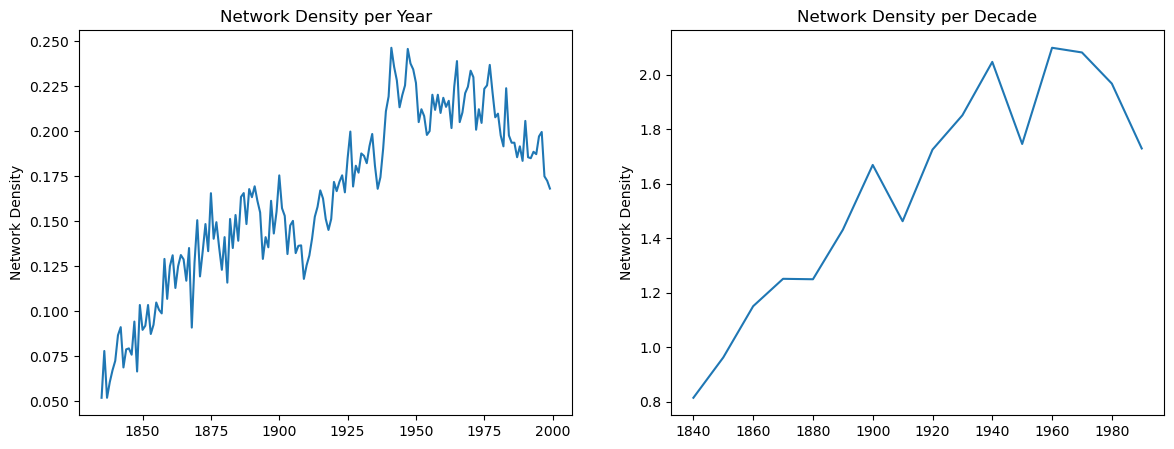

In [111]:
plot_characteristic_year_dec(yearly_densities, decade_densities, "Network Density")

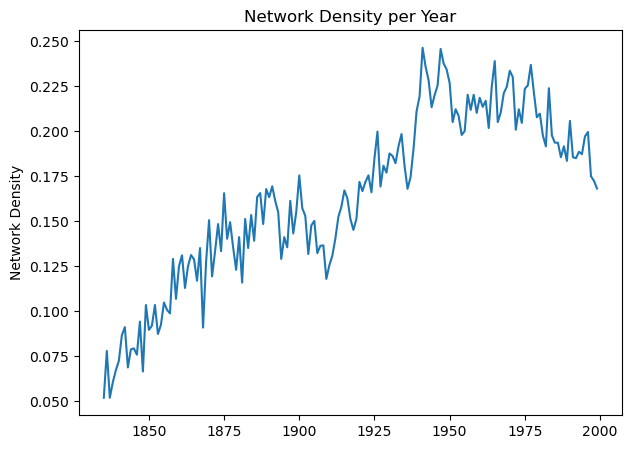

In [112]:
plot_characteristic(yearly_densities, "Network Density")

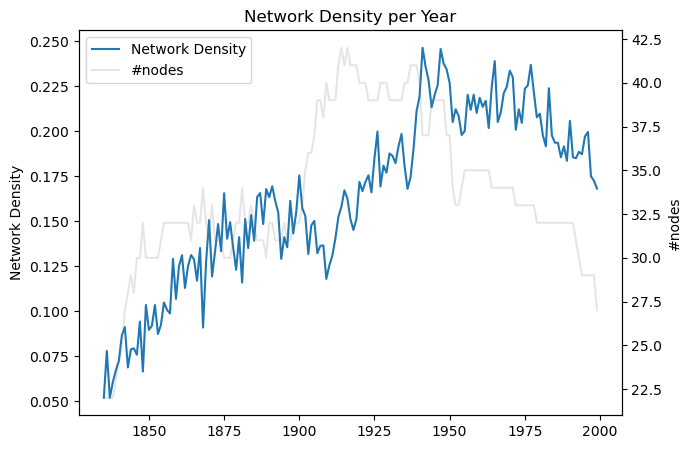

In [113]:
plot_yearly_with_nodefreq(yearly_densities, "Network Density")

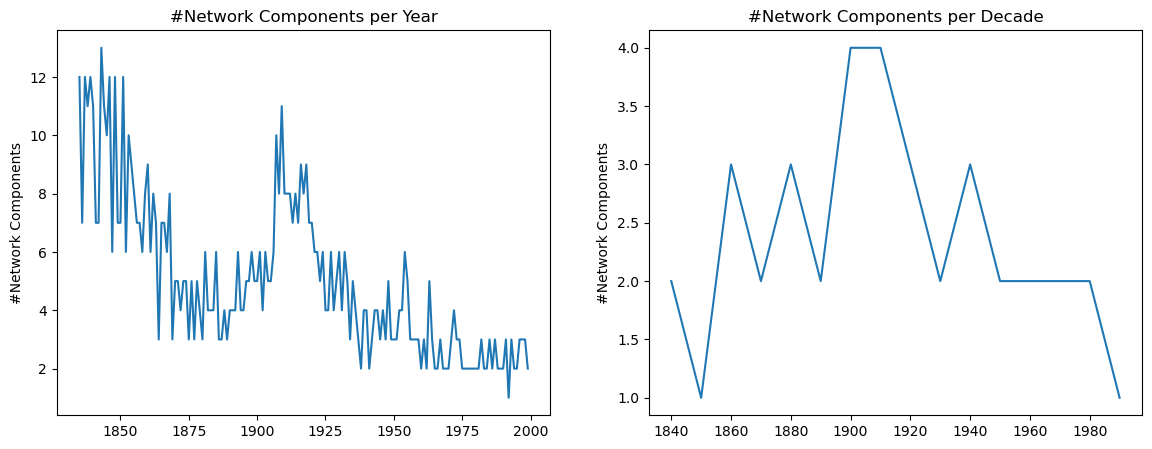

In [114]:
plot_characteristic_year_dec(yearly_components, decade_components, "#Network Components")

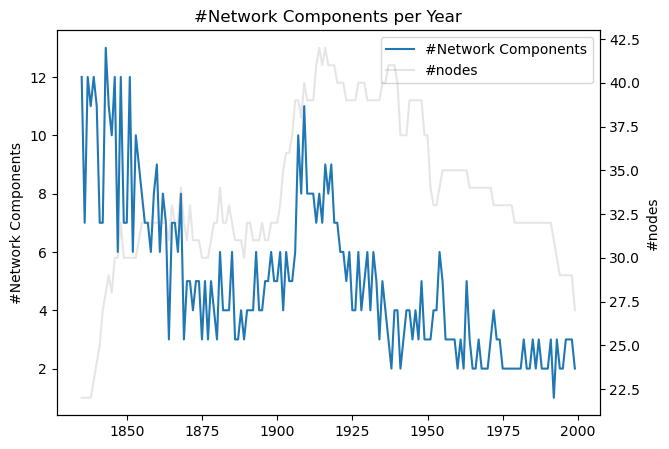

In [115]:
plot_yearly_with_nodefreq(yearly_components, "#Network Components")

### First Plotting
-> better with Gephi

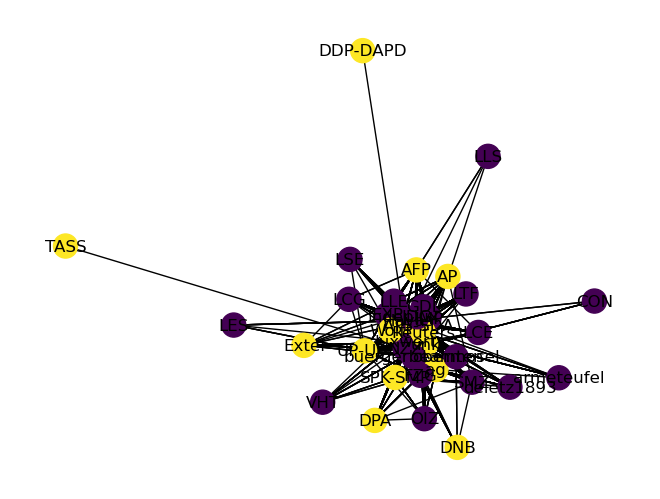

In [116]:
G_1900 = G.edge_subgraph([e[:3] for e in G.edges.data(keys=True) if e[3]["decade"] == 1900])
nx.draw(G_1900, with_labels=True, node_color=[node[1]['bipartite'] for node in G_1900.nodes.data()])

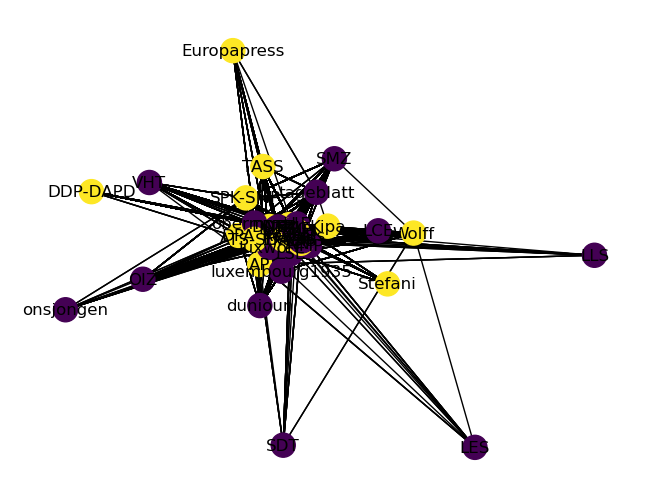

In [117]:
G_1940 = G.edge_subgraph([e[:3] for e in G.edges.data(keys=True) if e[3]["decade"] == 1940])
nx.draw(G_1940, with_labels=True, node_color=list(dict(G_1940.nodes.data("bipartite")).values()))

## Saving Graphs

In [118]:
nx.write_gexf(G, output_path + "G_np_ag.gexf")
nx.write_gexf(G_yearly, output_path + "G_yearly.gexf")
nx.write_gexf(G_newspaper, output_path + "G_np.gexf")
nx.write_gexf(G_agencies, output_path + "G_ag.gexf")

In [124]:
nx.write_gexf(G_yearly_min6, output_path + "G_yearly_min6.gexf")
nx.write_gexf(G_yearly_min24, output_path + "G_yearly_min24.gexf")
